## GCN代码解读

In [9]:
from __future__ import division
from __future__ import print_function
import time
import tensorflow as tf
from gcn.utils import *
from gcn.models import GCN, MLP

### 设置随机因子

In [12]:
seed = 123
np.random.seed(seed)
tf.set_random_seed(seed)

### 定义数据集、模型等命令行参数集

In [ ]:
flags = tf.app.flags
FLAGS = flags.FLAGS 

flags.DEFINE_string('dataset', 'cora', 'Dataset string.')  # 数据集 包括'cora', 'citeseer', 'pubmed' 
flags.DEFINE_string('model', 'gcn', 'Model string.')  # 模型 包括'gcn', 'gcn_cheby', 'dense' 
flags.DEFINE_float('learning_rate', 0.01, 'Initial learning rate.') # 学习率 0.01
flags.DEFINE_integer('epochs', 200, 'Number of epochs to train.') # 训练epoch次数 10
flags.DEFINE_integer('hidden1', 16, 'Number of units in hidden layer 1.') # 隐藏层的单元数 16
flags.DEFINE_float('dropout', 0.5, 'Dropout rate (1 - keep probability).') # dropout参数 0.5
flags.DEFINE_float('weight_decay', 5e-4, 'Weight for L2 loss on embedding matrix.') # 权重衰减 5e-4
flags.DEFINE_integer('early_stopping', 10, 'Tolerance for early stopping (# of epochs).') # early stopping 10
flags.DEFINE_integer('max_degree', 3, 'Maximum Chebyshev polynomial degree.') # 最大切比雪夫多项式次数

### 接下来加载数据集 原始数据集的文件表示：
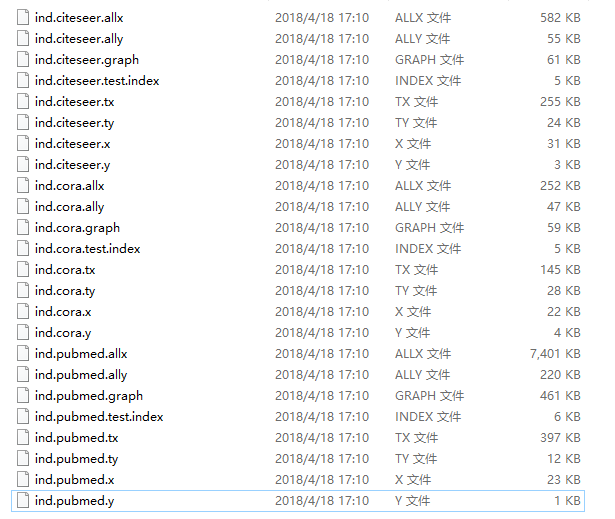
ind.dataset_str.x => 训练实例的特征向量 数据类型为scipy.sparse.csr.csr_matrix

ind.dataset_str.tx => 测试实例的特征向量 数据类型为scipy.sparse.csr.csr_matrix

ind.dataset_str.allx => 标记实例和未标记实例的特征向量 为ind.dataset_str.x的一个超集
数据类型为scipy.sparse.csr.csr_matrix

ind.dataset_str.y => 训练实例的标签(one-hot) 数据类型为numpy.ndarray

ind.dataset_str.ally => ind.dataset_str.allx中实例的标签 数据类型为numpy.ndarray

ind.dataset_str.graph => 图的字典存储形式 e.g., {index: [index of neighbor_nodes]}数据类型为collections.defaultdict

ind.dataset_str.test.index => 图中测试实例的索引 数据类型为list



### 加载数据集

 adj : 邻接矩阵
 
 features : 特征矩阵 
 
 y_train : 训练实例的标签 
 
 y_val : 校验实例的标签 500个
 
 y_test : 测试实例的标签
 
 train_mask : 训练实例标识 bool类型
 
 val_mask : 校验实例标识 bool类型
 
 test_mask : 测试实例标识 bool类型

#### adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask = load_data(FLAGS.dataset)
#### 部分结果:
adj: 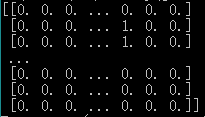
features：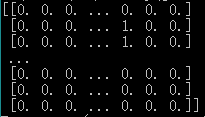
y_train(共7个类别): 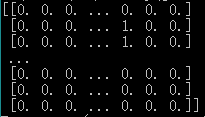

#### 对特征和邻接矩阵进行归一化

In [ ]:
features = preprocess_features(features)
support = [preprocess_adj(adj)]
num_supports = 1
model_func = GCN

#### 定义Tensor存储空间

In [ ]:
placeholders = {
    'support': [tf.sparse_placeholder(tf.float32) for _ in range(num_supports)],
    'features': tf.sparse_placeholder(tf.float32, shape=tf.constant(features[2], dtype=tf.int64)),
    'labels': tf.placeholder(tf.float32, shape=(None, y_train.shape[1])),
    'labels_mask': tf.placeholder(tf.int32),
    'dropout': tf.placeholder_with_default(0., shape=()),
    'num_features_nonzero': tf.placeholder(tf.int32)  # helper variable for sparse dropout
}

### 建立模型

In [ ]:
model = model_func(placeholders, input_dim=features[2][1], logging=True)  # 这里调用GCN函数构建GCN模型
# Initialize session
sess = tf.Session()

#### GCN模型部分代码

In [ ]:
class Model(object):
    def __init__(self, **kwargs):
        allowed_kwargs = {'name', 'logging'}
        for kwarg in kwargs.keys():
            assert kwarg in allowed_kwargs, 'Invalid keyword argument: ' + kwarg
        name = kwargs.get('name')
        if not name:
            name = self.__class__.__name__.lower()
        self.name = name

        logging = kwargs.get('logging', False)
        self.logging = logging

        self.vars = {}
        self.placeholders = {}

        self.layers = []
        self.activations = []

        self.inputs = None
        self.outputs = None

        self.loss = 0
        self.accuracy = 0
        self.optimizer = None
        self.opt_op = None

    def _build(self):
        raise NotImplementedError

    def build(self):
        """ Wrapper for _build() """
        with tf.variable_scope(self.name):
            self._build()

        # Build sequential layer model 搭建卷积网络模型
        self.activations.append(self.inputs)
        for layer in self.layers:
            hidden = layer(self.activations[-1]) # 隐藏层
            self.activations.append(hidden) 
        self.outputs = self.activations[-1]

        # Store model variables for easy access 模型的变量存储
        variables = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=self.name)
        self.vars = {var.name: var for var in variables}

        # Build metrics
        self._loss()
        self._accuracy()

        self.opt_op = self.optimizer.minimize(self.loss)

    def predict(self):
        pass

    def _loss(self):
        raise NotImplementedError

    def _accuracy(self):
        raise NotImplementedError

    def save(self, sess=None):
        if not sess:
            raise AttributeError("TensorFlow session not provided.")
        saver = tf.train.Saver(self.vars)
        save_path = saver.save(sess, "tmp/%s.ckpt" % self.name)
        print("Model saved in file: %s" % save_path)

    def load(self, sess=None):
        if not sess:
            raise AttributeError("TensorFlow session not provided.")
        saver = tf.train.Saver(self.vars)
        save_path = "tmp/%s.ckpt" % self.name
        saver.restore(sess, save_path)
        print("Model restored from file: %s" % save_path)
        
class GCN(Model):
    def __init__(self, placeholders, input_dim, **kwargs):
        super(GCN, self).__init__(**kwargs)

        self.inputs = placeholders['features']
        self.input_dim = input_dim # 输入维度
        # self.input_dim = self.inputs.get_shape().as_list()[1]  # To be supported in future Tensorflow versions
        self.output_dim = placeholders['labels'].get_shape().as_list()[1] # 输出维度
        self.placeholders = placeholders

        self.optimizer = tf.train.AdamOptimizer(learning_rate=FLAGS.learning_rate) # 定义优化器：Adam 学习率为0.01

        self.build()

    def _loss(self):
        # 权重衰减
        for var in self.layers[0].vars.values():
            self.loss += FLAGS.weight_decay * tf.nn.l2_loss(var)

        # 交叉熵损失函数
        self.loss += masked_softmax_cross_entropy(self.outputs, self.placeholders['labels'],
                                                  self.placeholders['labels_mask'])

    def _accuracy(self):
        self.accuracy = masked_accuracy(self.outputs, self.placeholders['labels'],
                                        self.placeholders['labels_mask'])

    def _build(self):
        # 论文采用两层卷积网络 即只有一层隐藏层
        # 输入层到隐藏层的参数定义
        self.layers.append(GraphConvolution(input_dim=self.input_dim,
                                            output_dim=FLAGS.hidden1,
                                            placeholders=self.placeholders,
                                            act=tf.nn.relu, # 激活函数选用ReLU函数
                                            dropout=True, # 采用dropout以避免过拟合
                                            sparse_inputs=True, 
                                            logging=self.logging))
        # 隐藏层到输出层的参数定义
        self.layers.append(GraphConvolution(input_dim=FLAGS.hidden1,
                                            output_dim=self.output_dim,
                                            placeholders=self.placeholders,
                                            act=lambda x: x,
                                            dropout=True,
                                            logging=self.logging))

    def predict(self):
        return tf.nn.softmax(self.outputs)

#### 定义模型的评估函数

In [ ]:
def evaluate(features, support, labels, mask, placeholders):
    t_test = time.time()
    feed_dict_val = construct_feed_dict(features, support, labels, mask, placeholders)
    # 利用之前模型中定义的交叉熵损失函数和正确率作为模型的评估标准
    outs_val = sess.run([model.loss, model.accuracy], feed_dict=feed_dict_val)
    return outs_val[0], outs_val[1], (time.time() - t_test)
sess.run(tf.global_variables_initializer())

#### 训练模型

In [ ]:
cost_val = []
for epoch in range(FLAGS.epochs):
# 采用批次梯度优化策略 epochs=200 
    t = time.time()
    # Construct feed dictionary
    feed_dict = construct_feed_dict(features, support, y_train, train_mask, placeholders)
    feed_dict.update({placeholders['dropout']: FLAGS.dropout}) # 添加dropout

    # 训练阶段 调用model的opt_op方法 利用Adam优化器进行模型的训练
    outs = sess.run([model.opt_op, model.loss, model.accuracy], feed_dict=feed_dict)

    # 校验阶段 利用定义的评估函数计算模型的损失值以及正确率 并记录时间
    cost, acc, duration = evaluate(features, support, y_val, val_mask, placeholders)
    cost_val.append(cost)

    # 输出结果
    print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(outs[1]),
          "train_acc=", "{:.5f}".format(outs[2]), "val_loss=", "{:.5f}".format(cost),
          "val_acc=", "{:.5f}".format(acc), "time=", "{:.5f}".format(time.time() - t))
    # early stopping
    if epoch > FLAGS.early_stopping and cost_val[-1] > np.mean(cost_val[-(FLAGS.early_stopping+1):-1]):
        print("Early stopping...")
        break

print("Optimization Finished!")

训练阶段的部分结果：
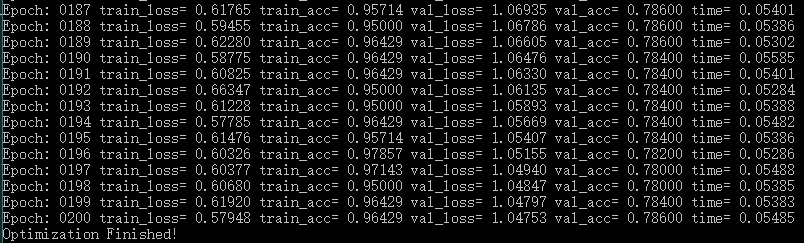

#### 模型测试

In [ ]:
test_cost, test_acc, test_duration = evaluate(features, support, y_test, test_mask, placeholders)
print("Test set results:", "cost=", "{:.5f}".format(test_cost),
      "accuracy=", "{:.5f}".format(test_acc), "time=", "{:.5f}".format(test_duration))

最终测试结果：
